In [1]:
import os
import gc
import time

import numpy
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from tqdm import tqdm # To see the progress bar
import PIL.Image as Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as F


In [3]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
import torchvision.transforms.functional as F
from torchvision import models

In [83]:
# Classic ML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [4]:

# Preprocessing transformations
Transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
IMAGE_DIMENSION = 256

In [6]:
# Define data transformations
data_transforms = {
    'train': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.RandomResizedCrop(224),
        # T.RandomHorizontalFlip(),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),

        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.CenterCrop(224),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),


        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [7]:
def apply_label_encoding_to_data(data: pd.DataFrame) -> pd.DataFrame:
    class_label_mapping = {}  # Dictionary to map class labels to indices
    unique_classes = data['label'].unique()  # Assuming 'label' is the column containing class labels in your CSV file

    for idx, class_label in enumerate(unique_classes):
        class_label_mapping[class_label] = idx

    # Convert the class labels in your dataset to numeric format
    data['label'] = data['label'].map(class_label_mapping)
    return data

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, labels_path, images_path, transform=None, target_transform=None):
        super().__init__()
        labels = pd.read_csv(labels_path)[:1000]
        if target_transform:
            labels = target_transform(labels)


        self.img_labels = labels

        self.img_dir = images_path

        self.transform = transform

    def __len__(self):
        return min(np.max(self.img_labels['id']), len(os.listdir(self.img_dir)))
        # return len(self.img_labels) - 1

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:

        (id, label) = self.img_labels.iloc[idx]
        img_path = os.path.join(self.img_dir, str(id) + ".jpg")
        image = to_pil_image(read_image(img_path))

        # image=to_grayscale(image)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


    @property
    def classes(self):
        return self.img_labels['label'].nunique()

In [9]:
class TripletDataset(Dataset):
    """
    This dataset is used for Triplet NN. Here each item is a tuple of three images:
    Anchor, Positive and Negative. This dataset doesn't provide the labels for images:
    we use comparing of images to train a model; so,
    whether the labels are equal IS OUR CRITERIA, not the labels itself.
    """
    def __init__(self, labels_path, images_path, transform=None):
        super().__init__()
        labels = pd.read_csv(labels_path)
        self.img_labels = labels
        self.img_dir = images_path
        self.transform = transform

    def __len__(self):
        a = np.max(self.img_labels['id'])
        b = len(os.listdir(self.img_dir))
        assert a == b
        return a
        # return min(np.max(self.img_labels['id']), len(os.listdir(self.img_dir)))
        # return len(self.img_labels) - 1

    def __get_data_row(self, idx):
        """
        This function gets item label and id.
        :param idx: Pythonic item number (supposed to start from 0)
        :return:
            1) item id (which is equal to image name if the folder) (may start from both 0 or 1, or even other)
            2) label
        """
        id_value, label = self.img_labels.iloc[idx]
        return id_value, label


    def __get_image(self, img_id, kind="anchor", label=None) -> tuple[torch.Tensor, int]:
        img_path = os.path.join(self.img_dir, str(img_id) + ".jpg")
        image = to_pil_image(read_image(img_path))
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        anchor_id, label = self.__get_data_row(idx)
        anchor = self.__get_image(img_id=anchor_id)

        positive_index = np.random.choice(np.where(self.img_labels['label'] == label)[0])
        positive_id, _ = self.__get_data_row(positive_index)
        positive = self.__get_image(img_id=positive_id)

        negative_labels = np.where(self.img_labels['label'] != label)[0]
        negative_index = np.random.choice(negative_labels)
        negative_id, _ = self.__get_data_row(negative_index)
        negative = self.__get_image(img_id=negative_id)

        return anchor, positive, negative


    @property
    def classes_(self):
        return self.img_labels['label'].unique()





In [10]:
data_path = '../'

In [11]:
# DATA_PATH = {
#     'train': {
#         'images': data_path + "cars_data/train",
#         'labels': data_path + "cars_data/train_labels.csv"
#     },
#     'test': {
#         'images': data_path + "cars_data/test",
#         'labels': data_path + "cars_data/test_labels.csv"
#     },
#     'val': {
#         'images': data_path + "cars_data/test",
#         'labels': data_path + "cars_data/test_labels.csv"
#     },
# }
DATA_PATH = {
    'train': {
        'images': data_path + "Cropped_dogs/train",
        'labels': data_path + "Dogs/train_labels.csv"
    },
    'test': {
        'images': data_path + "Cropped_dogs/test",
        'labels': data_path + "Dogs/test_labels.csv"
    },
    'val': {
        'images': data_path + "Cropped_dogs/val",
        'labels': data_path + "Dogs/val_labels.csv"
    },
}

In [33]:
# train_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['train']['labels'],
#     images_path=DATA_PATH['train']['images'],
#     transform=data_transforms['train'],
#     target_transform=apply_label_encoding_to_data
# )
# test_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['test']['labels'],
#     images_path=DATA_PATH['test']['images'],
#     transform=data_transforms['test'],
#     target_transform=apply_label_encoding_to_data
# )
# val_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['val']['labels'],
#     images_path=DATA_PATH['val']['images'],
#     transform=data_transforms['test'],
#     target_transform=apply_label_encoding_to_data
# )

NameError: name 'CustomImageDataset' is not defined

In [12]:
train_dataset = TripletDataset(
    labels_path=DATA_PATH['train']['labels'],
    images_path=DATA_PATH['train']['images'],
    transform=data_transforms['train'],
)
# test_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['test']['labels'],
#     images_path=DATA_PATH['test']['images'],
#     transform=data_transforms['test'],
#     target_transform=apply_label_encoding_to_data
# )
val_dataset = TripletDataset(
    labels_path=DATA_PATH['val']['labels'],
    images_path=DATA_PATH['val']['images'],
    transform=data_transforms['test'],
)

In [13]:
BATCH_SIZE = 16

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = models.resnet18(weights='IMAGENET1K_V1')

Our Resnet model has 1000 out features. We will replace this number with **64**

In [16]:
model.fc = nn.Linear(model.fc.in_features, 64)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Triplet Loss Implementation

In [18]:
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)

Before the training, let's see how our criterion works

In [19]:
def show_loss(loss_list: list) -> None:
    plt.plot(loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.show()


In [20]:
loss_history = []

Now we will calculate our loss for some items in dataset.

In [69]:
dataset = val_dataset
for i in range(len(dataset)):
    anchor = dataset[i][0]
    positive = dataset[i][1]
    negative = dataset[i][2]

    with torch.no_grad():
        features1 = model(anchor.unsqueeze(0))
        features2 = model(positive.unsqueeze(0))
        features3 = model(negative.unsqueeze(0))


    anchor_embedding = torch.flatten(features1, start_dim=1)
    epositive_mbedding = torch.flatten(features2, start_dim=1)
    negative_embedding = torch.flatten(features3, start_dim=1)

    loss = triplet_criterion(anchor_embedding, epositive_mbedding, negative_embedding)

    # embeddings_data.append(embedding1)
    loss_history.append(loss)



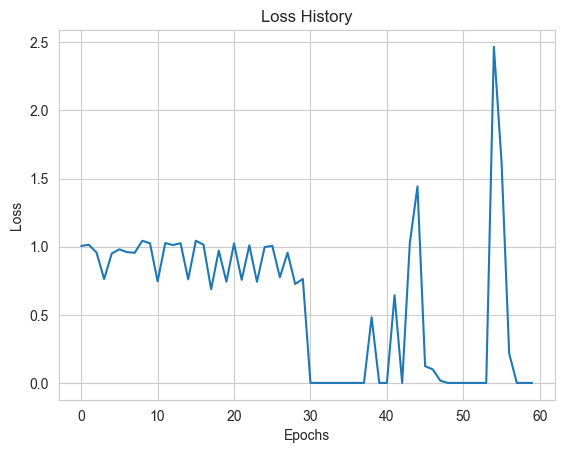

In [70]:
show_loss(loss_history)

As long as we haven't train model yet, loss func is not minimized and loss is distributed randomly: model cannot recognize class relationship between images. So, any attempt to train classic ML classification algorithm (e.g. KNN) is going to failure - embeddings don't tell enough and they poorly capture the similarities and differences between images.
To address this issue and correctly locate the vectors, we need to train our model using the Triplet Loss.


## Clustering

Let's see how well our data can be divided into classes

In [44]:
def collect_embeddings(model: nn.Module, data: TripletDataset, device='cpu') -> np.array:
    """
    In this function we will extract ony Anchor images and process them
    return: np.Array with embeddings of images
    """
    embeddings = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i in range(len(data)):
            anchor_image = data[i][0]
            embedding = model(anchor_image.unsqueeze(0))
            embeddings.append(embedding.numpy())

    return np.squeeze(np.array(embeddings), axis=1)  # We remove extra axis, so we get (N, B) instead of (N, 1, B)

In [45]:
val_embeddings = collect_embeddings(
    model=model,
    data=val_dataset,
    device=device
)

In [46]:
train_embeddings = collect_embeddings(
    model=model,
    data=train_dataset,
    device=device
)

In [255]:
def reduce_dimension(dimension, features, reduce_with='pca',) -> None:
    """ Perform dimensionality reduction with PCA or t-SNE """

    if reduce_with == 'tsne' and dimension < 4:
        reductor = TSNE(n_components=dimension, perplexity=25.0)
    else: # PCA
        reductor = PCA(n_components=dimension)

    reduced_features = reductor.fit_transform(features)
    return reduced_features

In [283]:
def cluster_and_visualize_embeddings(embeddings, reduce_embeddings_to=None, dimension=2, cluster_with='knn', reduce_with='pca', eps=2):
    """ Function to cluster the data and visualize it in low-dimensional space"""
    assert cluster_with in ['knn', 'dbscan']
    assert reduce_with in ['pca', 'tsne']

    if reduce_embeddings_to:
        embeddings = reduce_dimension(
            dimension=reduce_embeddings_to,
            features=embeddings,
            reduce_with=reduce_with
        )

    if cluster_with == 'knn':
        kmeans = KMeans(n_clusters=10)
        clusters = kmeans.fit_predict(embeddings)
    else:
        # EPS = 1.8 is a good value
        dbscan = DBSCAN(eps=eps, min_samples=4, metric='euclidean')
        clusters = dbscan.fit_predict(embeddings)
        print(clusters)

    # return

    # Now we reduce data again so that we can plot it.
    reduced_embeddings = reduce_dimension(
        dimension=dimension,
        features=embeddings,
        reduce_with=reduce_with
    )


    # Plot the clusters in 3D or 2D
    fig = plt.figure()
    if dimension == 2:
        ax = fig.add_subplot(111)
        dots = (reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    elif dimension == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlabel('Dimension 3')
        dots = (reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2]
        )

    plt.scatter(*dots, c=clusters, cmap='viridis')
    ax.set_title('Cluster Visualization')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    plt.show()


D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


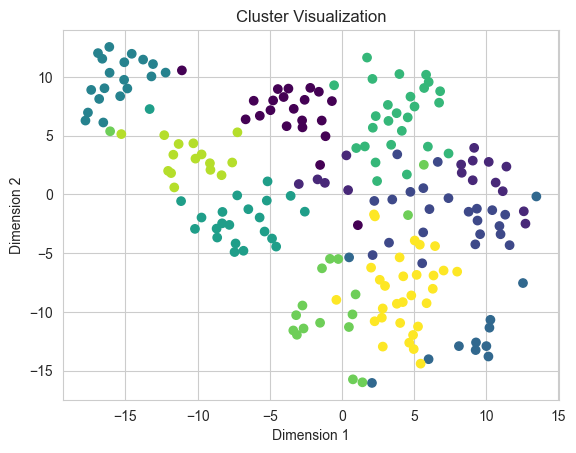

In [292]:
cluster_and_visualize_embeddings(train_embeddings,
    dimension=2,
    reduce_embeddings_to=8,
    cluster_with='knn',
    reduce_with='tsne',
    eps=1.92
)

|We can see that clustering failed

### NN Fine-Tuning

In [55]:
def train_iteration(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for (anchor, positive, negative) in tepoch:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # tepoch.set_postfix(loss=loss.item())
        time.sleep(0.01)

    epoch_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for (anchor, positive, negative) in val_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            val_loss += loss.item()

    torch.cuda.empty_cache()
    val_loss /= len(val_loader)

    return epoch_loss, val_loss


In [56]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    plt.show()

In [57]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, scheduler=None, device='cpu'):
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)

        for epoch in range(num_epochs):
            epoch_loss, val_loss = train_iteration(model, train_loader, val_loader, criterion, optimizer, device)
            print(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}"
            )

            train_loss_history.append(epoch_loss)
            valid_loss_history.append(val_loss)

            if scheduler is not None:
                scheduler.step()  # Update learning rate

            del epoch_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        plot_stats(
            train_loss_history, valid_loss_history,
            title="Model "
        )
    return model

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)

In [60]:
num_epochs = 15

100%|██████████| 13/13 [02:22<00:00, 10.96s/batch]


Epoch 1/15 - Train Loss: 0.3459 - Val Loss: 0.1124


100%|██████████| 13/13 [02:25<00:00, 11.19s/batch]


Epoch 2/15 - Train Loss: 0.1102 - Val Loss: 0.1183


100%|██████████| 13/13 [02:23<00:00, 11.02s/batch]


Epoch 3/15 - Train Loss: 0.1016 - Val Loss: 0.0078


100%|██████████| 13/13 [02:21<00:00, 10.87s/batch]


Epoch 4/15 - Train Loss: 0.0534 - Val Loss: 0.0000


100%|██████████| 13/13 [02:19<00:00, 10.75s/batch]


Epoch 5/15 - Train Loss: 0.0295 - Val Loss: 0.0375


100%|██████████| 13/13 [02:21<00:00, 10.86s/batch]


Epoch 6/15 - Train Loss: 0.0457 - Val Loss: 0.0745


100%|██████████| 13/13 [02:21<00:00, 10.92s/batch]


Epoch 7/15 - Train Loss: 0.0576 - Val Loss: 0.0818


100%|██████████| 13/13 [02:19<00:00, 10.73s/batch]


Epoch 8/15 - Train Loss: 0.0608 - Val Loss: 0.0052


100%|██████████| 13/13 [02:27<00:00, 11.35s/batch]


Epoch 9/15 - Train Loss: 0.0218 - Val Loss: 0.0897


100%|██████████| 13/13 [02:27<00:00, 11.32s/batch]


Epoch 10/15 - Train Loss: 0.0481 - Val Loss: 0.0359


100%|██████████| 13/13 [02:26<00:00, 11.24s/batch]


Epoch 11/15 - Train Loss: 0.0235 - Val Loss: 0.1386


100%|██████████| 13/13 [02:25<00:00, 11.22s/batch]


Epoch 12/15 - Train Loss: 0.0104 - Val Loss: 0.1361


100%|██████████| 13/13 [02:26<00:00, 11.26s/batch]


Epoch 13/15 - Train Loss: 0.0188 - Val Loss: 0.0151


100%|██████████| 13/13 [02:22<00:00, 10.99s/batch]


Epoch 14/15 - Train Loss: 0.0307 - Val Loss: 0.0000


100%|██████████| 13/13 [02:23<00:00, 11.07s/batch]


Epoch 15/15 - Train Loss: 0.0112 - Val Loss: 0.0077
Training complete in 37m 52s


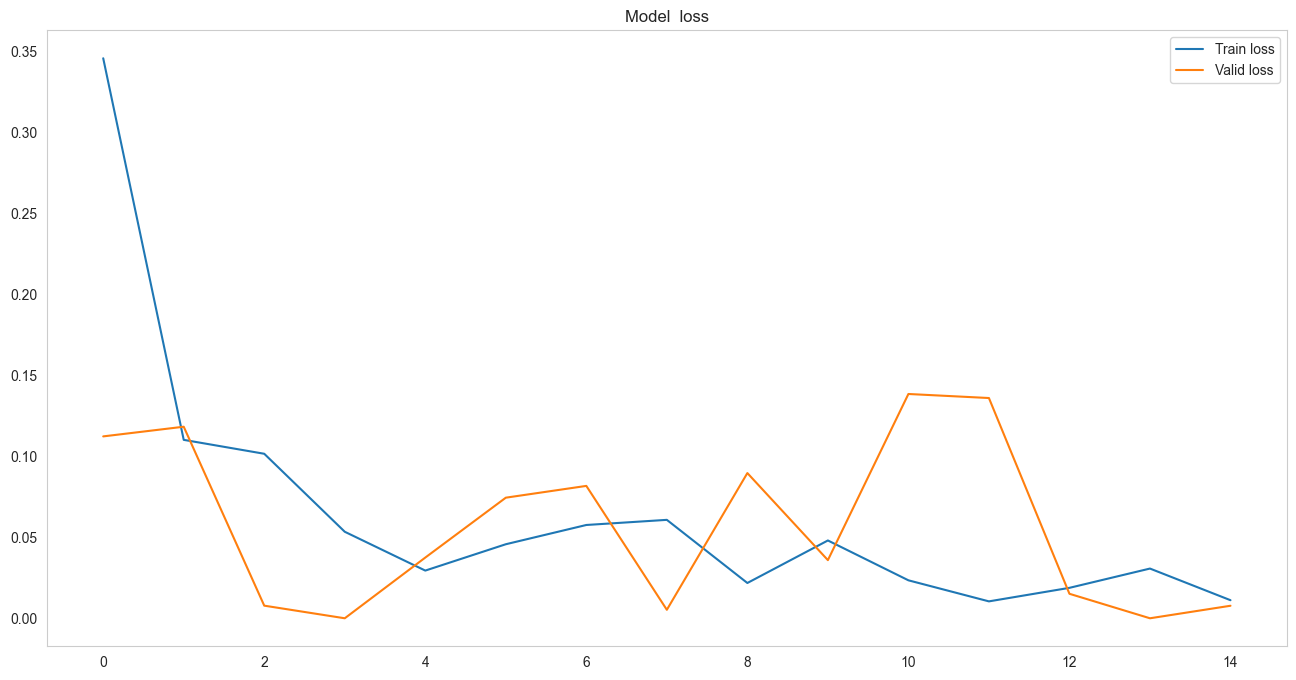

In [61]:
model = train_model(model=model,
                    train_loader=train_dataloader,
                    val_loader=val_dataloader,
                    criterion=triplet_criterion,
                    optimizer=optimizer,
                    num_epochs=num_epochs,
                    device=device)

Now, after trainig, let's try to cluster data again

D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


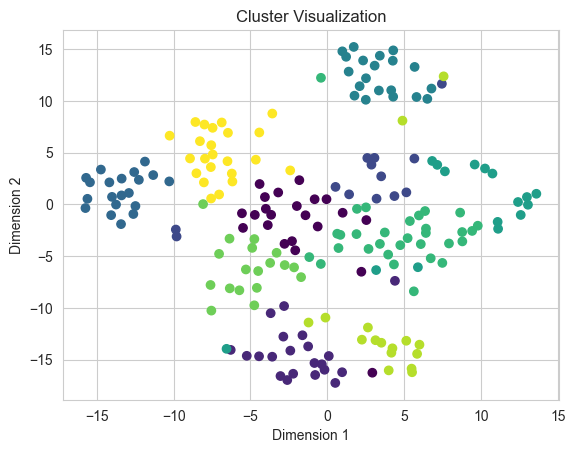

()

In [293]:
cluster_and_visualize_embeddings(
    embeddings=collect_embeddings(
        model=model,
        data=train_dataset,
        device=device
    ),
    dimension=2,
    reduce_embeddings_to=8,
    cluster_with='knn',
    reduce_with='tsne',
    eps=1.9,
)
(
)

Now we can train our classification model!

In [273]:
model = KMeans(n_clusters=10)

In [274]:
# Apply PCA for dimensionality reduction
pca = PCA(
    n_components=0.8
    # n_components=10,
)

In [275]:
X_train1 = pca.fit_transform(X_train)

In [276]:
X_train1.shape

(200, 69)

In [277]:
X_test1 = pca.transform(X_test)

In [278]:
scaler = StandardScaler()

In [279]:
X_train2 = scaler.fit_transform(X_train1)

In [280]:
X_test2 = scaler.transform(X_test1)

In [281]:
y_test = pd.read_csv(data_path + "Dogs/val_labels.csv")['label']

In [282]:
y_train = pd.read_csv(data_path + "Dogs/train_labels.csv")['label']

In [283]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can choose the number of neighbors (K) here

In [284]:
knn.fit(X_train2, y_train)

KNeighborsClassifier()

In [285]:
model.fit(X_train2)

D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [287]:
model.predict(X_test2)

array([3, 7, 1, 8, 5, 8, 6, 1, 6, 8, 8, 1, 7, 5, 6, 3, 1, 5, 7, 7, 3, 8,
       1, 3, 3, 1, 1, 5, 6, 3])

In [288]:
print(knn.predict(X_test2))

['chihuahua' 'bernese_mountain_dog' 'bernese_mountain_dog' 'chihuahua'
 'dachshund' 'jack_russell' 'golden_retriever' 'border_collie' 'chihuahua'
 'chihuahua' 'chihuahua' 'bernese_mountain_dog' 'chihuahua' 'corgi'
 'jack_russell' 'golden_retriever' 'dachshund' 'border_collie' 'dachshund'
 'jack_russell' 'border_collie' 'jack_russell' 'labrador' 'jack_russell'
 'jack_russell' 'jack_russell' 'jack_russell' 'border_collie'
 'bernese_mountain_dog' 'pug']


In [272]:
knn.score(X_test, y_test)

AttributeError: 'Flags' object has no attribute 'c_contiguous'

array(['bernese_mountain_dog', 'border_collie', 'chihuahua', 'corgi',
       'dachshund', 'golden_retriever', 'jack_russell', 'labrador', 'pug',
       'siberian_husky'], dtype=object)

In [228]:
print(classification_report(y_test, knn.predict(X_test2),
                            target_names=y_test.unique()))

                      precision    recall  f1-score   support

bernese_mountain_dog       0.25      0.67      0.36         3
       border_collie       0.00      0.00      0.00         3
           chihuahua       0.00      0.00      0.00         3
               corgi       0.33      0.33      0.33         3
           dachshund       0.25      0.33      0.29         3
    golden_retriever       0.00      0.00      0.00         3
        jack_russell       0.00      0.00      0.00         3
            labrador       1.00      0.33      0.50         3
                 pug       0.00      0.00      0.00         3
      siberian_husky       0.00      0.00      0.00         3

            accuracy                           0.17        30
           macro avg       0.18      0.17      0.15        30
        weighted avg       0.18      0.17      0.15        30



D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:

#define arrays
a = [[23, 34, 44, 45, 42, 27, 33, 34]]
b = [[17, 18, 22, 26, 26, 29, 31, 30]]

#calculate Cosine Similarity
cos_sim = np.dot(a[0], b[0])/(np.linalg.norm(a[0]) * np.linalg.norm(b[0]))

cos_sim

0.965195008357566

In [44]:
discriminator = nn.CosineSimilarity(dim=1, eps=1e-8)

In [45]:
torch.Tensor(a).permute(1, 0)

tensor([[23.],
        [34.],
        [44.],
        [45.],
        [42.],
        [27.],
        [33.],
        [34.]])

In [46]:
discriminator(torch.Tensor(a).permute(1, 0), torch.Tensor(b).permute(0, 1))

tensor([0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803])

In [38]:
torch.Tensor(a).permute(0, 1)

tensor([[23., 34., 44., 45., 42., 27., 33., 34.]])

In [39]:
torch.Tensor(b).permute(1, 0)

tensor([[17.],
        [18.],
        [22.],
        [26.],
        [26.],
        [29.],
        [31.],
        [30.]])